In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import os
import time
import copy
import idx2numpy

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
transform = transforms.Compose([transforms.Resize(28),
                                transforms.CenterCrop(28),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

In [64]:
image_set = torchvision.datasets.FashionMNIST('./FashionMNIST', download = True, transform=transforms.ToTensor())

In [65]:
test_set = torchvision.datasets.FashionMNIST('./FashionMNIST', download = True, train = False, transform=transforms.ToTensor())

In [66]:
train_loader = torch.utils.data.DataLoader(dataset=image_set, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = 32, shuffle = False)

In [67]:
print(image_set[0][0].shape)

torch.Size([1, 28, 28])


## Autoencoder

In [68]:
class AutoEnc(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,200),
                                    nn.BatchNorm1d(200),
                                    nn.SiLU())
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [69]:
model1 = AutoEnc().to(device)

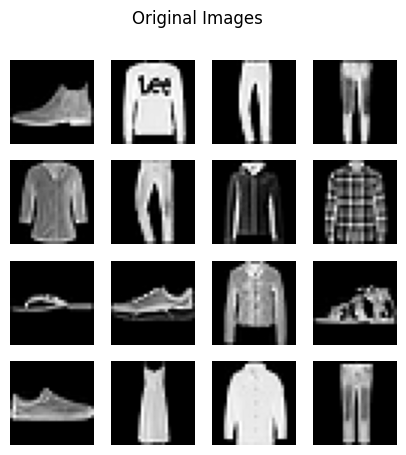

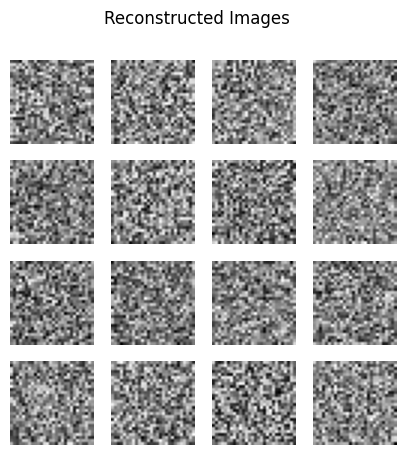

In [70]:
batch = next(iter(test_loader))
images,labels = batch
batch = images.to(device), labels.to(device)
preds = model1(batch[0]).detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [71]:
# Define the hyperparameters
# Using Adam optimizer
# Using OneCycleLR scheduler

epochs = 100
lr = 0.01
opt = torch.optim.Adam(model1.parameters(),lr = lr, eps = 1e-5)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr = lr,epochs = epochs,steps_per_epoch = len(train_loader))

In [72]:
# Train the model
# Using binary cross entropy loss

for epoch in range(epochs):
    losses = []
    model1.train()
    for batch in train_loader:
        batch = {i.to(device) for i in batch}
        images,labels = batch
        preds = model1(images)
        loss = F.binary_cross_entropy_with_logits(preds,images)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(losses):.4f}")
    losses = []
    model1.eval()
    for batch in test_loader:
        batch = {i.to(device) for i in batch}
        images,labels = batch
        preds = model1(images)
        loss = F.binary_cross_entropy_with_logits(preds,images)
        losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Valid Loss: {np.mean(losses):.4f}")

Epoch [1/100], Train Loss: 0.4900
Epoch [1/100], Valid Loss: 0.4101
Epoch [2/100], Train Loss: 0.3783
Epoch [2/100], Valid Loss: 0.3411
Epoch [3/100], Train Loss: 0.3268
Epoch [3/100], Valid Loss: 0.3059
Epoch [4/100], Train Loss: 0.3004
Epoch [4/100], Valid Loss: 0.2864
Epoch [5/100], Train Loss: 0.2881
Epoch [5/100], Valid Loss: 0.2788
Epoch [6/100], Train Loss: 0.2822
Epoch [6/100], Valid Loss: 0.2734
Epoch [7/100], Train Loss: 0.2792
Epoch [7/100], Valid Loss: 0.2714
Epoch [8/100], Train Loss: 0.2774
Epoch [8/100], Valid Loss: 0.2703


KeyboardInterrupt: 

In [22]:
# Save the model

model = model1.cpu()
torch.save(model,'autoencoder.pth')

In [23]:
# Load the model

model = torch.load('autoencoder.pth')

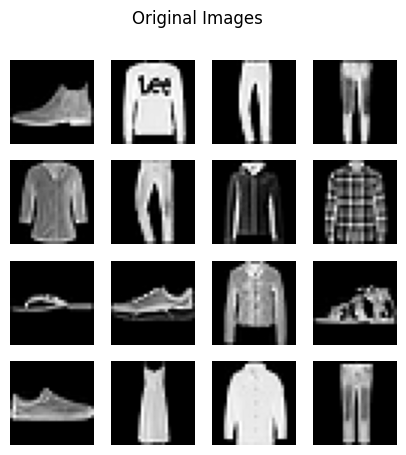

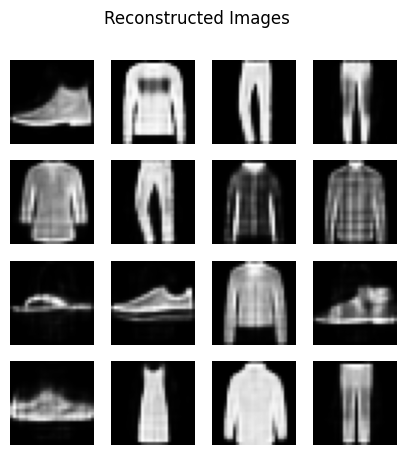

In [24]:
batch = next(iter(test_loader))
images,labels = batch
batch = images.to(device), labels.to(device)
preds = model(batch[0]).detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

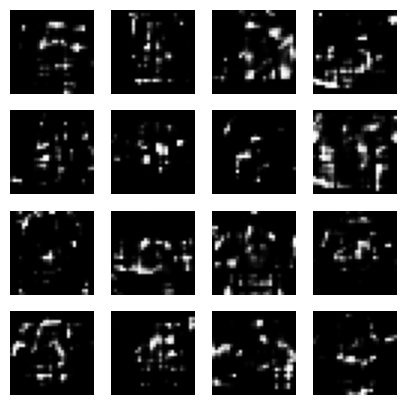

In [29]:
# Try to generate new images from random noise
# As the model is trained to reconstruct the images, it is not able to generate new images from random noise

random_noise = torch.randn(16,1,28,28)
preds = model(random_noise).detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

## Variational Autoencoder

In [30]:
num_epochs = 100
learning_rate = 0.01

In [31]:
class VarAutoEnc(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU())
        
        self.mu = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))

        self.logvar = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return self.decoder(z),mu,logvar

In [41]:
def KL_Divergence(mu, log_var):
    return -0.5*(1 + log_var - mu.pow(2) - log_var.exp()).mean()

def BCE(input, target):
    BCE = F.binary_cross_entropy_with_logits(input, target)
    return BCE

In [42]:
model = VarAutoEnc().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr = lr,epochs = epochs,steps_per_epoch = len(train_loader))

In [43]:
torch.save(model.state_dict(), "vae1.pt")
since = time.time()
best_acc = 0.0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-'*10)
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        recon_imgs, mu, log_var = model(inputs)
        kl_loss = KL_Divergence(mu, log_var)
        bce_loss = BCE(recon_imgs, inputs)
        loss =  kl_loss + bce_loss
        running_loss = loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Loss = {running_loss}")
torch.save(model.state_dict(), "vae100.pt")


time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

Epoch 1/20
----------
Loss = 0.39424365758895874
Epoch 2/20
----------
Loss = 0.3727790117263794
Epoch 3/20
----------
Loss = 0.36923983693122864
Epoch 4/20
----------
Loss = 0.34939712285995483
Epoch 5/20
----------
Loss = 0.3942471742630005
Epoch 6/20
----------
Loss = 0.36166366934776306
Epoch 7/20
----------
Loss = 0.3714323043823242
Epoch 8/20
----------
Loss = 0.3347703218460083
Epoch 9/20
----------
Loss = 0.36441776156425476
Epoch 10/20
----------
Loss = 0.34890151023864746
Epoch 11/20
----------
Loss = 0.3277638554573059
Epoch 12/20
----------
Loss = 0.3360436260700226
Epoch 13/20
----------
Loss = 0.3475995659828186
Epoch 14/20
----------
Loss = 0.3649248480796814
Epoch 15/20
----------
Loss = 0.36230242252349854
Epoch 16/20
----------
Loss = 0.34264567494392395
Epoch 17/20
----------
Loss = 0.35155540704727173
Epoch 18/20
----------
Loss = 0.3300136625766754
Epoch 19/20
----------
Loss = 0.38175755739212036
Epoch 20/20
----------
Loss = 0.32563504576683044
Training complete 

In [56]:
model = VarAutoEnc()
model.load_state_dict(torch.load('vae100.pt'))
model.eval()

VarAutoEnc(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=400, bias=True)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): SiLU()
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SiLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (logvar): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Linear(in_features=400,

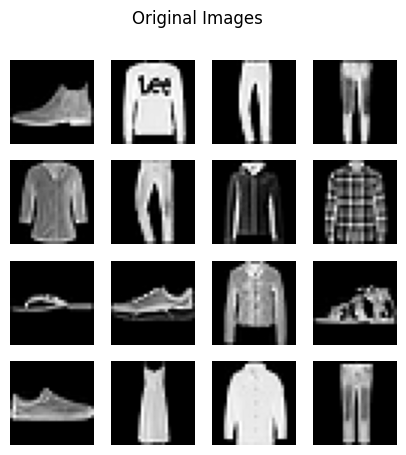

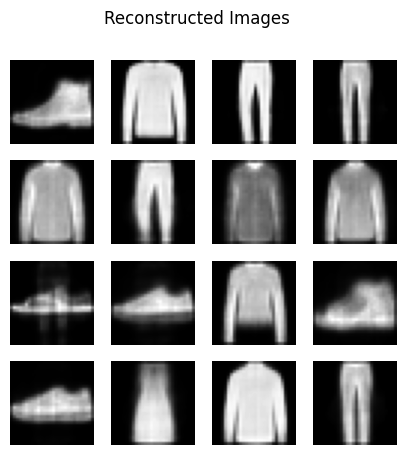

In [57]:
batch = next(iter(test_loader))
images,labels = batch
preds = model(images)[0].detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

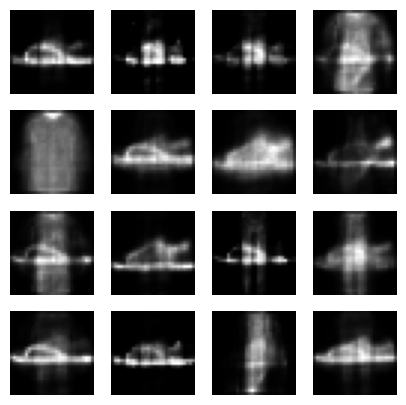

In [60]:
# Try to generate new images from random noise
# As you can see, the model is able to generate new images from random noise

random_noise = torch.randn(16,1,28,28)
preds = model(random_noise)[0].detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')